In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision import models
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings(action='ignore')

In [176]:
# Data Loading
df = pd.read_csv('./Data/inverse_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2462 entries, 0 to 2461
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2462 non-null   object 
 1   Open    2462 non-null   int64  
 2   High    2462 non-null   int64  
 3   Low     2462 non-null   int64  
 4   Close   2462 non-null   int64  
 5   Volume  2462 non-null   int64  
 6   Change  2462 non-null   float64
dtypes: float64(1), int64(5), object(1)
memory usage: 134.8+ KB


In [177]:
# orginal data
original_close = df['Close'].values

# separate dates for future plotting
dates = pd.to_datetime(df['Date'])

# variables for training
cols = ['Open', 'High', 'Low', 'Close', 'Volume']

# new dataframe with only training data - 5 columns
df = df[cols].astype(float)

# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df)
stock_data_scaled = scaler.transform(df)

# split to train data and test data
n_train = int(0.9*stock_data_scaled.shape[0])
train_data_scaled = stock_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = stock_data_scaled[n_train:]
test_dates = dates[n_train:]

In [178]:
pred_days = 1
seq_len = 7
batch = 100

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 0:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 1:i + pred_days, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 0:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 1:i + pred_days, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

print(f"trainX:{trainX.shape}, testX:{testX.shape}, trainY:{trainY.shape}, testY:{testY.shape}")

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

trainX:(2208, 7, 5), testX:(240, 7, 5), trainY:(2208, 1), testY:(240, 1)


In [197]:
# Hyper Parameter
num_classes = 1 #number of output classes 

input_size = 5
hidden_size = 25
num_layers = 1

learning_rate = 0.0001
nb_epochs = 300

class LSTM(nn.Module):
    # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        self.num_classes = num_classes 
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers 
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True)

        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer
        self.relu = nn.ReLU()

    def forward(self, x) :
        # Propagate input through LSTM
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
           
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # lstm with input, hidden, and internal state

        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output

        return out

In [181]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 1, patience = 5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            # H(x) 계산
            outputs = model.forward(x_train)
            # cost 계산
            loss = criterion(outputs, y_train)                 
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss.item()/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break

    return model.eval(), train_hist

In [198]:
# 모델 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM(num_classes, input_size, hidden_size, num_layers).to(device)
trained_model, train_hist = train_model(model, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

Epoch: 0000 train loss : 0.9098
Epoch: 0020 train loss : 0.0227
Epoch: 0040 train loss : 0.0072
Epoch: 0060 train loss : 0.0052
Epoch: 0080 train loss : 0.0045
Epoch: 0100 train loss : 0.0039
Epoch: 0120 train loss : 0.0035
Epoch: 0140 train loss : 0.0031
Epoch: 0160 train loss : 0.0027
Epoch: 0180 train loss : 0.0023
Epoch: 0200 train loss : 0.0020
Epoch: 0220 train loss : 0.0018
Epoch: 0240 train loss : 0.0016
Epoch: 0260 train loss : 0.0015
Epoch: 0280 train loss : 0.0014


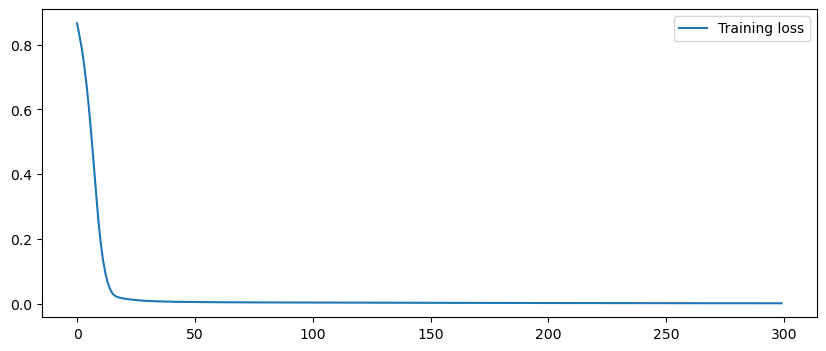

In [183]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

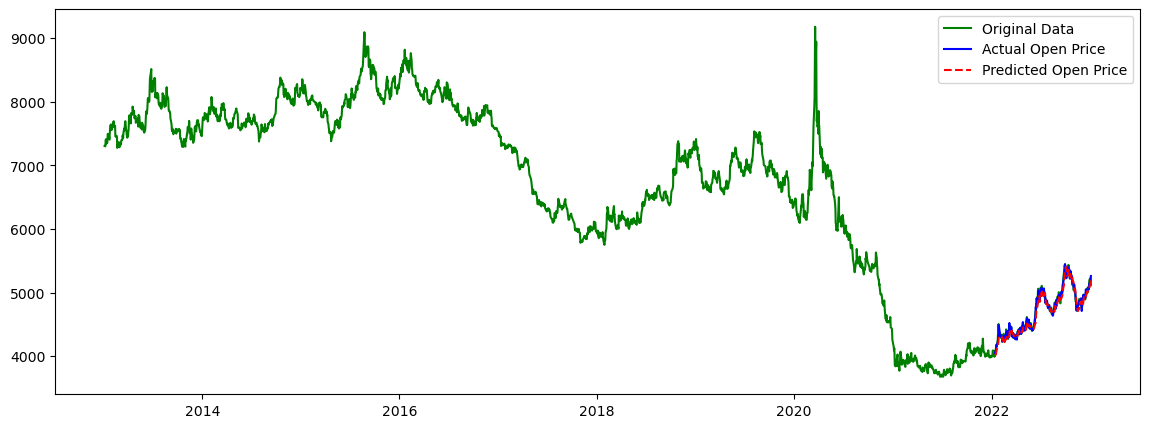

In [191]:
train_predict = trained_model(testX_tensor)
prediction = train_predict.data.numpy()
label_y = testY_tensor.data.numpy()

mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)
mean_values_pred[:, 0] = np.squeeze(prediction)
y_pred = scaler.inverse_transform(mean_values_pred)[:, 0]

mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)
mean_values_testY[:, 0] = np.squeeze(testY)
testY_original = scaler.inverse_transform(mean_values_testY)[:, 0]


plt.figure(figsize=(14, 5))
plt.plot(dates, original_close, color='green', label = 'Original Data')
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Open Price')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Open Price')
plt.legend()
plt.show()

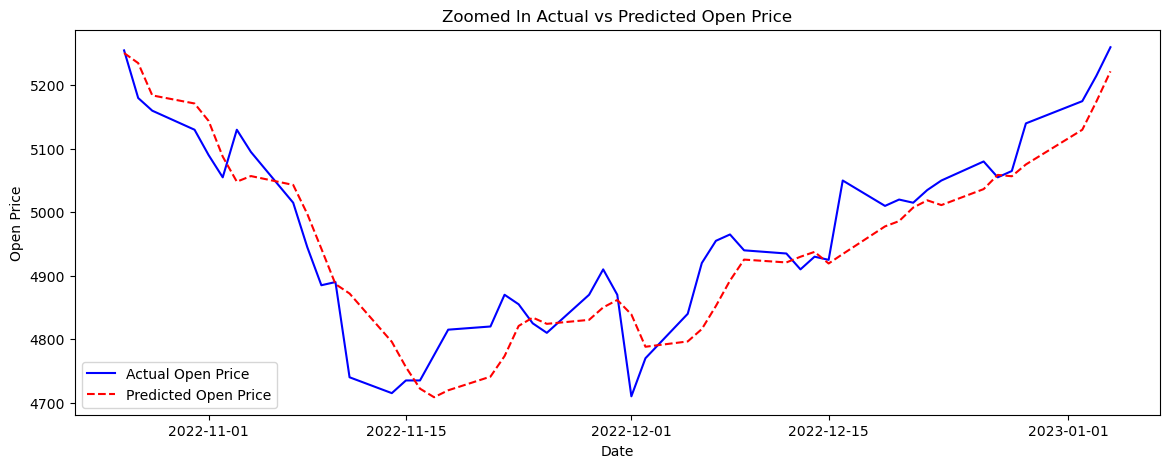

In [188]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 50
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Open Price')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Open Price')

plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Zoomed In Actual vs Predicted Open Price')
plt.legend()
plt.show()